### In this notebook, we'll delve into the general process of model conversion for the Deep Learning Processing Unit (DPU) in Vitis AI. We'll highlight the benefits of employing the Vitis Inspector before initiating the model training process.

### We will construct a basic model using PyTorch to train on the MNIST dataset, with the ultimate aim of targeting the B4096 DPU on the ZCU104 platform.Let's get started.

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Normalize
from IPython.display import Image

#Model Definition
class ToyModel(nn.Module):
    def __init__(self):
        super(ToyModel, self).__init__()
        
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(in_features=256*20*20, out_features=64),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=64, out_features=32),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=32, out_features=10)
        )
        
    def forward(self, x):
        out = self.net(x)
        return out

# No Inspection
### It is recommended to inspect the model that we just created to see if all the operations/parameters are supported by DPU before further proceeding to training phase. For now lets not inspect the model and move to next of training it.

In [2]:
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f"Training on {device}")

# Load MNIST dataset
train_dataset = MNIST(root='./data', train=True, transform=ToTensor(), download=True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Load the MNIST test dataset
test_dataset = MNIST(root='./data', train=False, transform=ToTensor())
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Create model and optimizer
model = ToyModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

Training on cuda


In [3]:
# Training loop
for epoch in range(5):
    for images, labels in train_loader:
        # Move data to GPU
        images, labels = images.to(device), labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        
        # Compute loss
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
    # Print loss for each epoch
    print(f"Epoch {epoch+1} loss: {loss.item()}")

# Save the model
torch.save(model.state_dict(), "toy_model.pth")


Epoch 1 loss: 0.0011225442867726088
Epoch 2 loss: 0.002250030869618058
Epoch 3 loss: 0.010395124554634094
Epoch 4 loss: 0.00022440621978603303
Epoch 5 loss: 0.0015127313090488315


In [4]:
#Testing Loop

def test(model, device, test_loader):
    # Evaluate the model on the test set
    model.eval()
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for images, labels in test_loader:
            # Forward pass
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Compute predictions and accuracy
            _, predictions = torch.max(F.softmax(outputs, dim=1), dim=1)
            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)

        # Compute overall accuracy
        accuracy = total_correct / total_samples
        print(f"Test accuracy: {accuracy:.2f}")
        
test(model,device, test_loader)

Test accuracy: 0.99


# Quantization

In [10]:
from pytorch_nndct.apis import torch_quantizer, dump_xmodel

def quantization(mode, batch_size):
        
    model = ToyModel().to(device)
    model.load_state_dict(torch.load("toy_model.pth"))
    
    optimize = 1
    
    random_data = torch.randn(batch_size,1,28,28)
    quantizer = torch_quantizer(mode, model, (random_data), output_dir="quantized")
    
    test_dataset = MNIST(root='./data', train=False, transform=ToTensor())
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    quantized_model = quantizer.quant_model

    test(quantized_model, device, test_loader)
    
    if mode == 'calib':
        quantizer.export_quant_config()
    if mode == 'test':
        quantizer.export_xmodel(deploy_check=False, output_dir="quantized")

In [11]:
quantization('calib',32) #We have used batch size 32 in the dataloader
print("Exporting quantized model")
quantization('test',1)  #For test batch size should be 1


[VAIQ_NOTE]: OS and CPU information:
               system --- Linux
                 node --- pop-os
              release --- 6.2.6-76060206-generic
              version --- #202303130630~1681329778~22.04~d824cd4 SMP PREEMPT_DYNAMIC Wed A
              machine --- x86_64
            processor --- x86_64

[VAIQ_NOTE]: Tools version information:
                  GCC --- GCC 9.4.0
               python --- 3.7.12
              pytorch --- 1.12.1
        vai_q_pytorch --- 3.0.0+a44284e+torch1.12.1

[VAIQ_NOTE]: GPU information:
          device name --- NVIDIA GeForce GTX 960M
     device available --- True
         device count --- 1
       current device --- 0

[VAIQ_NOTE]: Quant config file is empty, use default quant configuration

[VAIQ_NOTE]: Quantization calibration process start up...

[VAIQ_NOTE]: =>Quant Module is in 'cuda'.

[VAIQ_NOTE]: =>Parsing ToyModel...

[VAIQ_NOTE]: Start to trace and freeze model...

[VAIQ_NOTE]: The input model ToyModel is torch.nn.Module.

[VAIQ_N

██████████████████████████████████████████████████| 16/16 [00:00<00:00, 763.99it/s, OpInfo: name = return_0, type = Return]     


[VAIQ_NOTE]: =>Doing weights equalization...

[VAIQ_NOTE]: =>Quantizable module is generated.(quantized/ToyModel.py)

[VAIQ_NOTE]: =>Get module with quantization.


Test accuracy: 0.99

[VAIQ_NOTE]: =>Exporting quant config.(quantized/quant_info.json)

[VAIQ_NOTE]: OS and CPU information:
               system --- Linux
                 node --- pop-os
              release --- 6.2.6-76060206-generic
              version --- #202303130630~1681329778~22.04~d824cd4 SMP PREEMPT_DYNAMIC Wed A
              machine --- x86_64
            processor --- x86_64

[VAIQ_NOTE]: Tools version information:
                  GCC --- GCC 9.4.0
               python --- 3.7.12
              pytorch --- 1.12.1
        vai_q_pytorch --- 3.0.0+a44284e+torch1.12.1

[VAIQ_NOTE]: GPU information:
          device name --- NVIDIA GeForce GTX 960M
     device available --- True
         device count --- 1
       current device --- 0

[VAIQ_NOTE]: Quant config file is empty, use default quant configuration

[VAIQ_NOTE]: Quantization test process start up...

[VAIQ_NOTE]: =>Quant Module is in 'cuda'.

[VAIQ_NOTE]: =>Parsing ToyModel...

[VAIQ_NOTE]: Start to trace and fre

██████████████████████████████████████████████████| 16/16 [00:00<00:00, 654.25it/s, OpInfo: name = return_0, type = Return]     


[VAIQ_NOTE]: =>Doing weights equalization...

[VAIQ_NOTE]: =>Quantizable module is generated.(quantized/ToyModel.py)

[VAIQ_NOTE]: =>Get module with quantization.


Test accuracy: 0.99

[VAIQ_NOTE]: =>Converting to xmodel ...

[VAIQ_NOTE]: =>Successfully convert 'ToyModel' to xmodel.(quantized/ToyModel_int.xmodel)


In [15]:
#Checking the graph with xdputil
!xdputil  xmodel ./quantized/ToyModel_int.xmodel -p ./quantized/xmodel.png

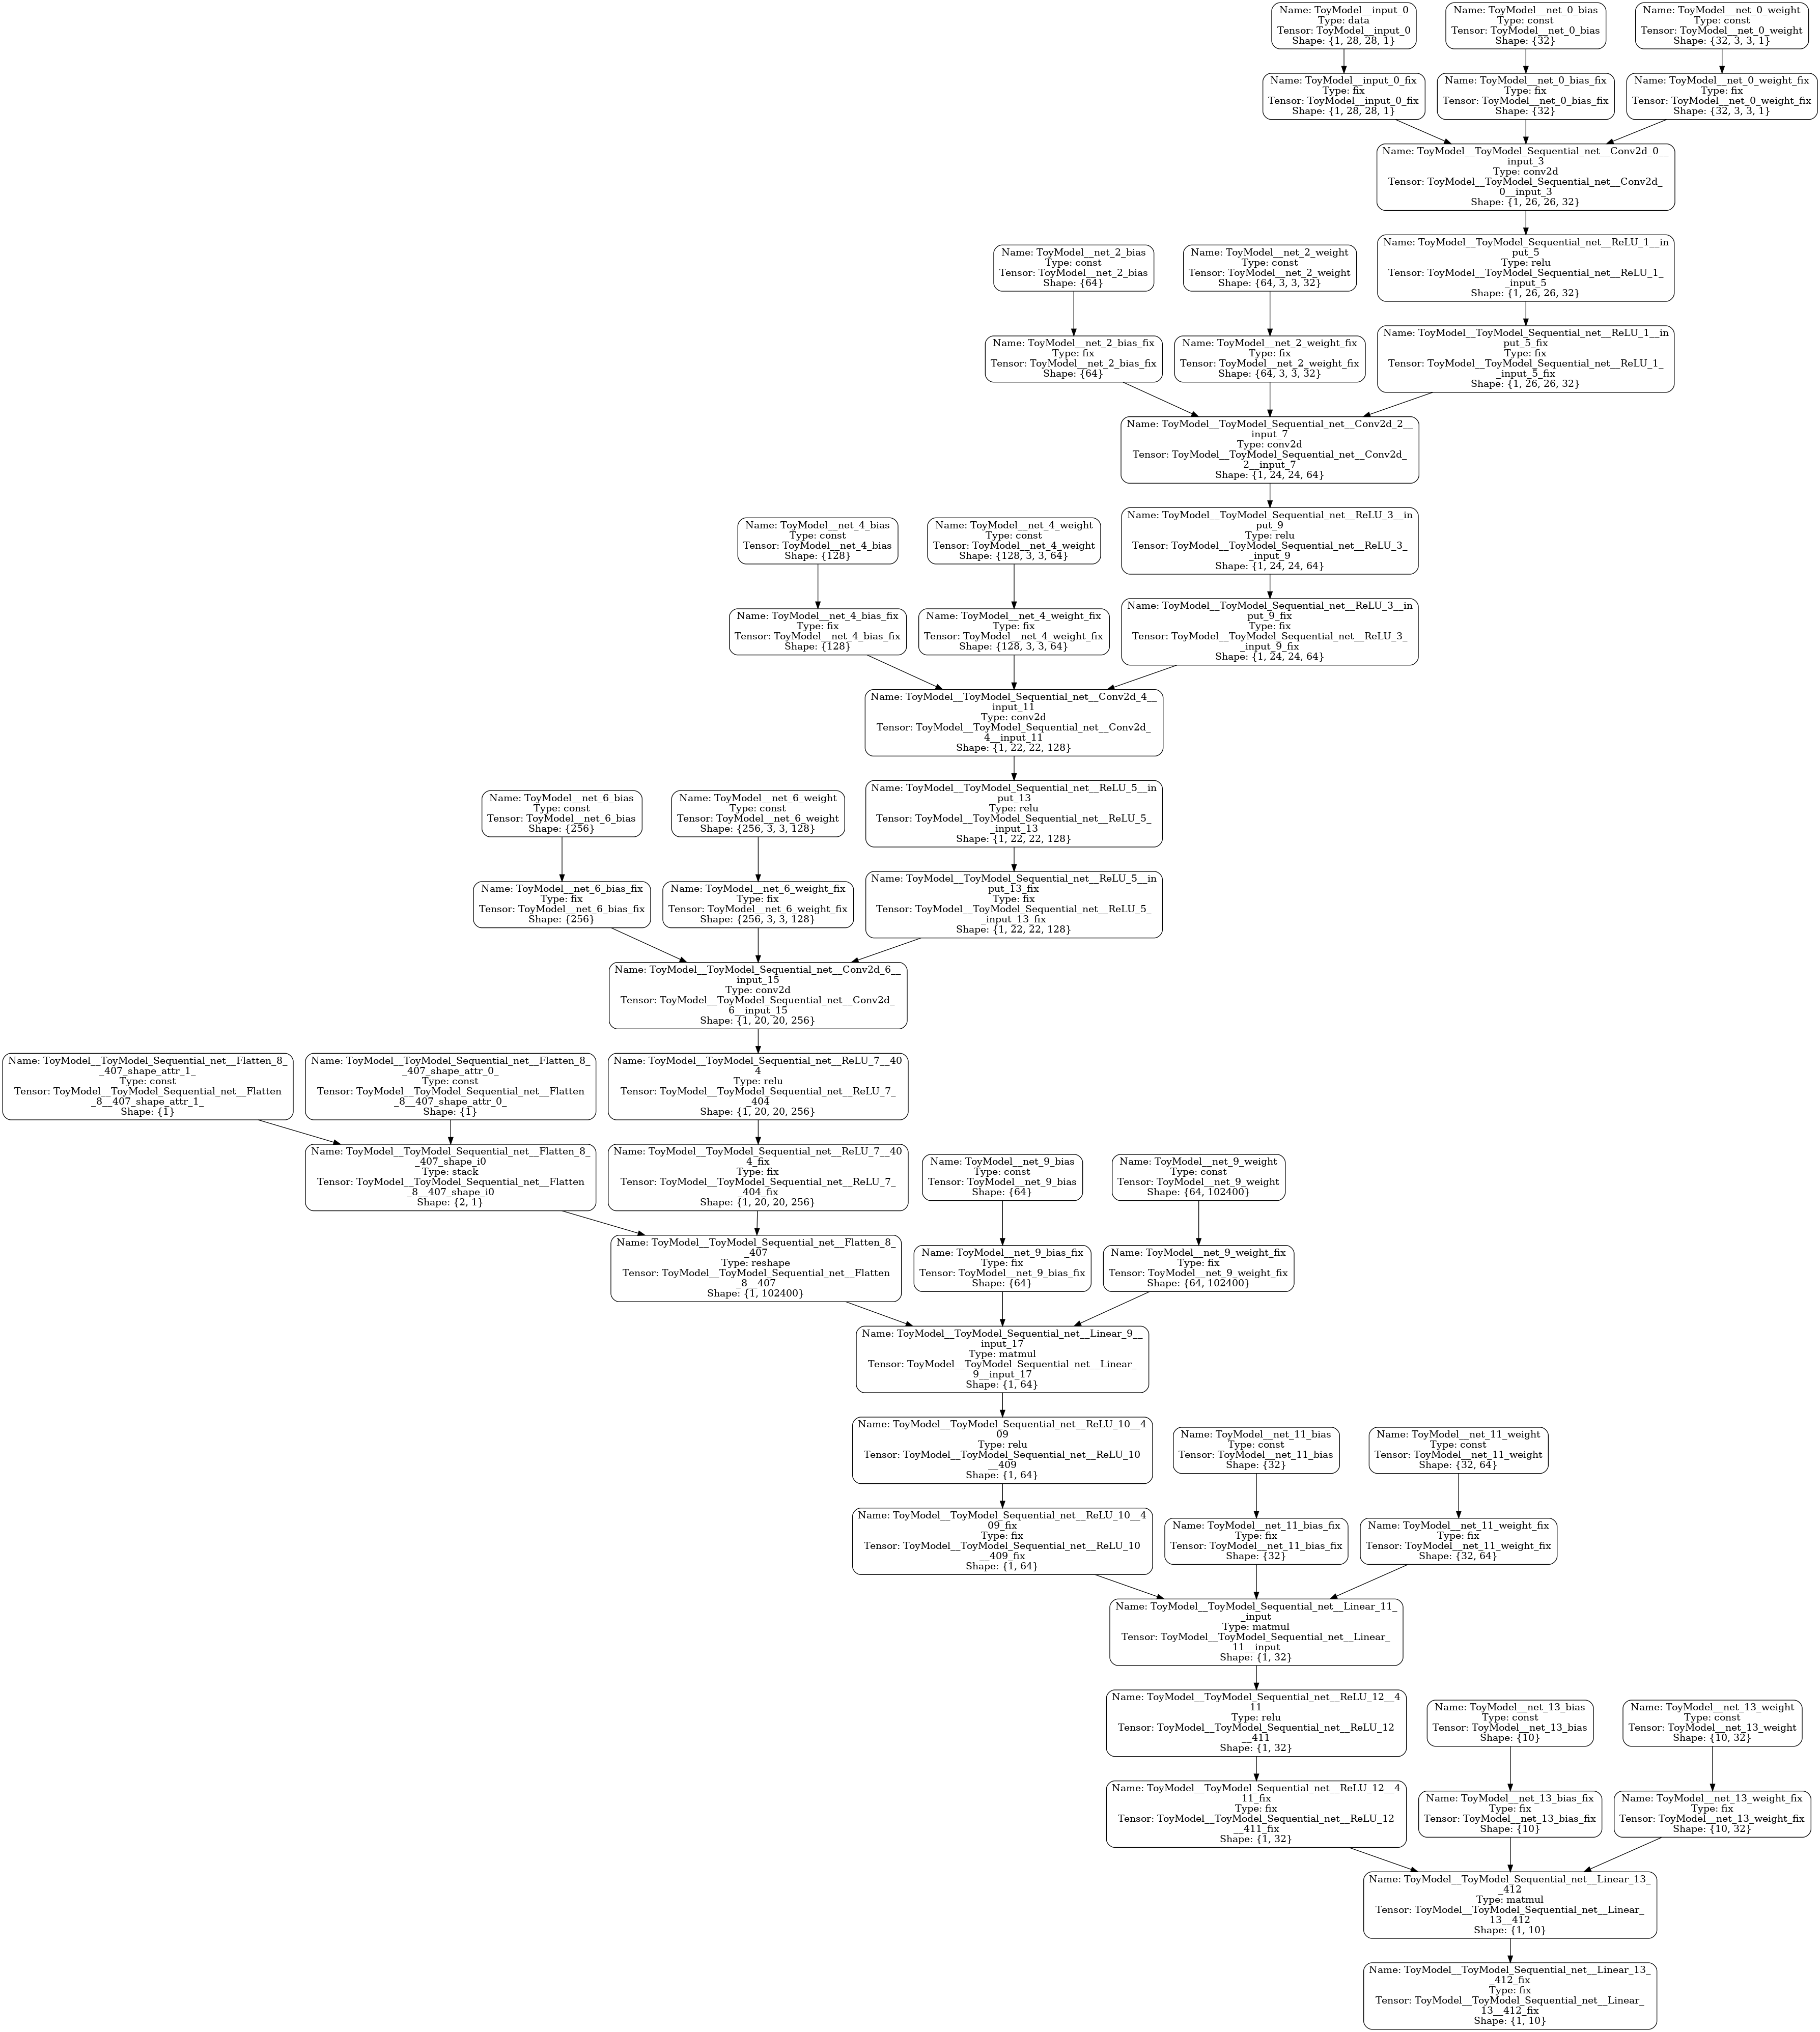

In [17]:
Image('quantized/xmodel.png')

### The quantizer generated no error and from the quantized graph we donot know if all the operations are marked for DPU.

# Compilation

### vai_c_xir is used to compile the PyTorch model

In [18]:
!vai_c_xir -h 

**************************************************
* VITIS_AI Compilation - Xilinx Inc.
**************************************************
usage: vai_c_xir [-h] [-x XMODEL] [-a ARCH] [-o OUTPUT_DIR] [-n NET_NAME]
                 [-e OPTIONS]

optional arguments:
  -h, --help            show this help message and exit
  -x XMODEL, --xmodel XMODEL
                        xmodel
  -a ARCH, --arch ARCH  json file
  -o OUTPUT_DIR, --output_dir OUTPUT_DIR
                        output directory
  -n NET_NAME, --net_name NET_NAME
                        prefix-name for the outputs
  -e OPTIONS, --options OPTIONS
                        extra options. Use --options '{"plugins":
                        "plugin0,plugin1"}' to specify plugin libraries. Use
                        --options '{"output_ops": "op_name0,op_name1"}' to
                        specify output ops. Use --options '{"hd_opt": "true"}'
                        to enable special optimization for HD input, the
               

In [19]:
!vai_c_xir --xmodel ./quantized/ToyModel_int.xmodel --arch ./arch.json --net_name cnn_zcu102 --output_dir ./compiled_model 
# arch.json file has the value {"fingerprint":"0x101000016010407"}, this is generated when DPU platform is created. 

**************************************************
* VITIS_AI Compilation - Xilinx Inc.
**************************************************
[UNILOG][INFO] Compile mode: dpu
[UNILOG][INFO] Debug mode: null
[UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096_0101000016010407
[UNILOG][INFO] Graph name: ToyModel, with op num: 54
[UNILOG][INFO] Begin to compile...
[UNILOG][WARNING] xir::Op{name = ToyModel__ToyModel_Sequential_net__Linear_9__input_17(TransferMatMulToConv2d), type = conv2d-fix} has been assigned to CPU: [Weights(64, 8, 8, 1600) is too large to be loaded into parameter buffer. "kernel_h * kernel_w * kernel_d(=1 for conv2d) * ⌈input_channel / weights_bank_width⌉ * ⌈output_channel_parallel / weights_bank_num⌉"(6400) is supposed to be less equal than 2048].
[UNILOG][WARNING] xir::Op{name = ToyModel__net_9_weight(reshaped), type = const-fix} has been assigned to CPU: [Has no fanout or at least one fanout is out of DPU subgraph.].
[UNILOG][WARNING] xir::Op{name = ToyModel__net_

In [20]:
!xdputil  xmodel ./compiled_model/cnn_zcu102.xmodel -p ./compiled_model/compiled_xmodel.png

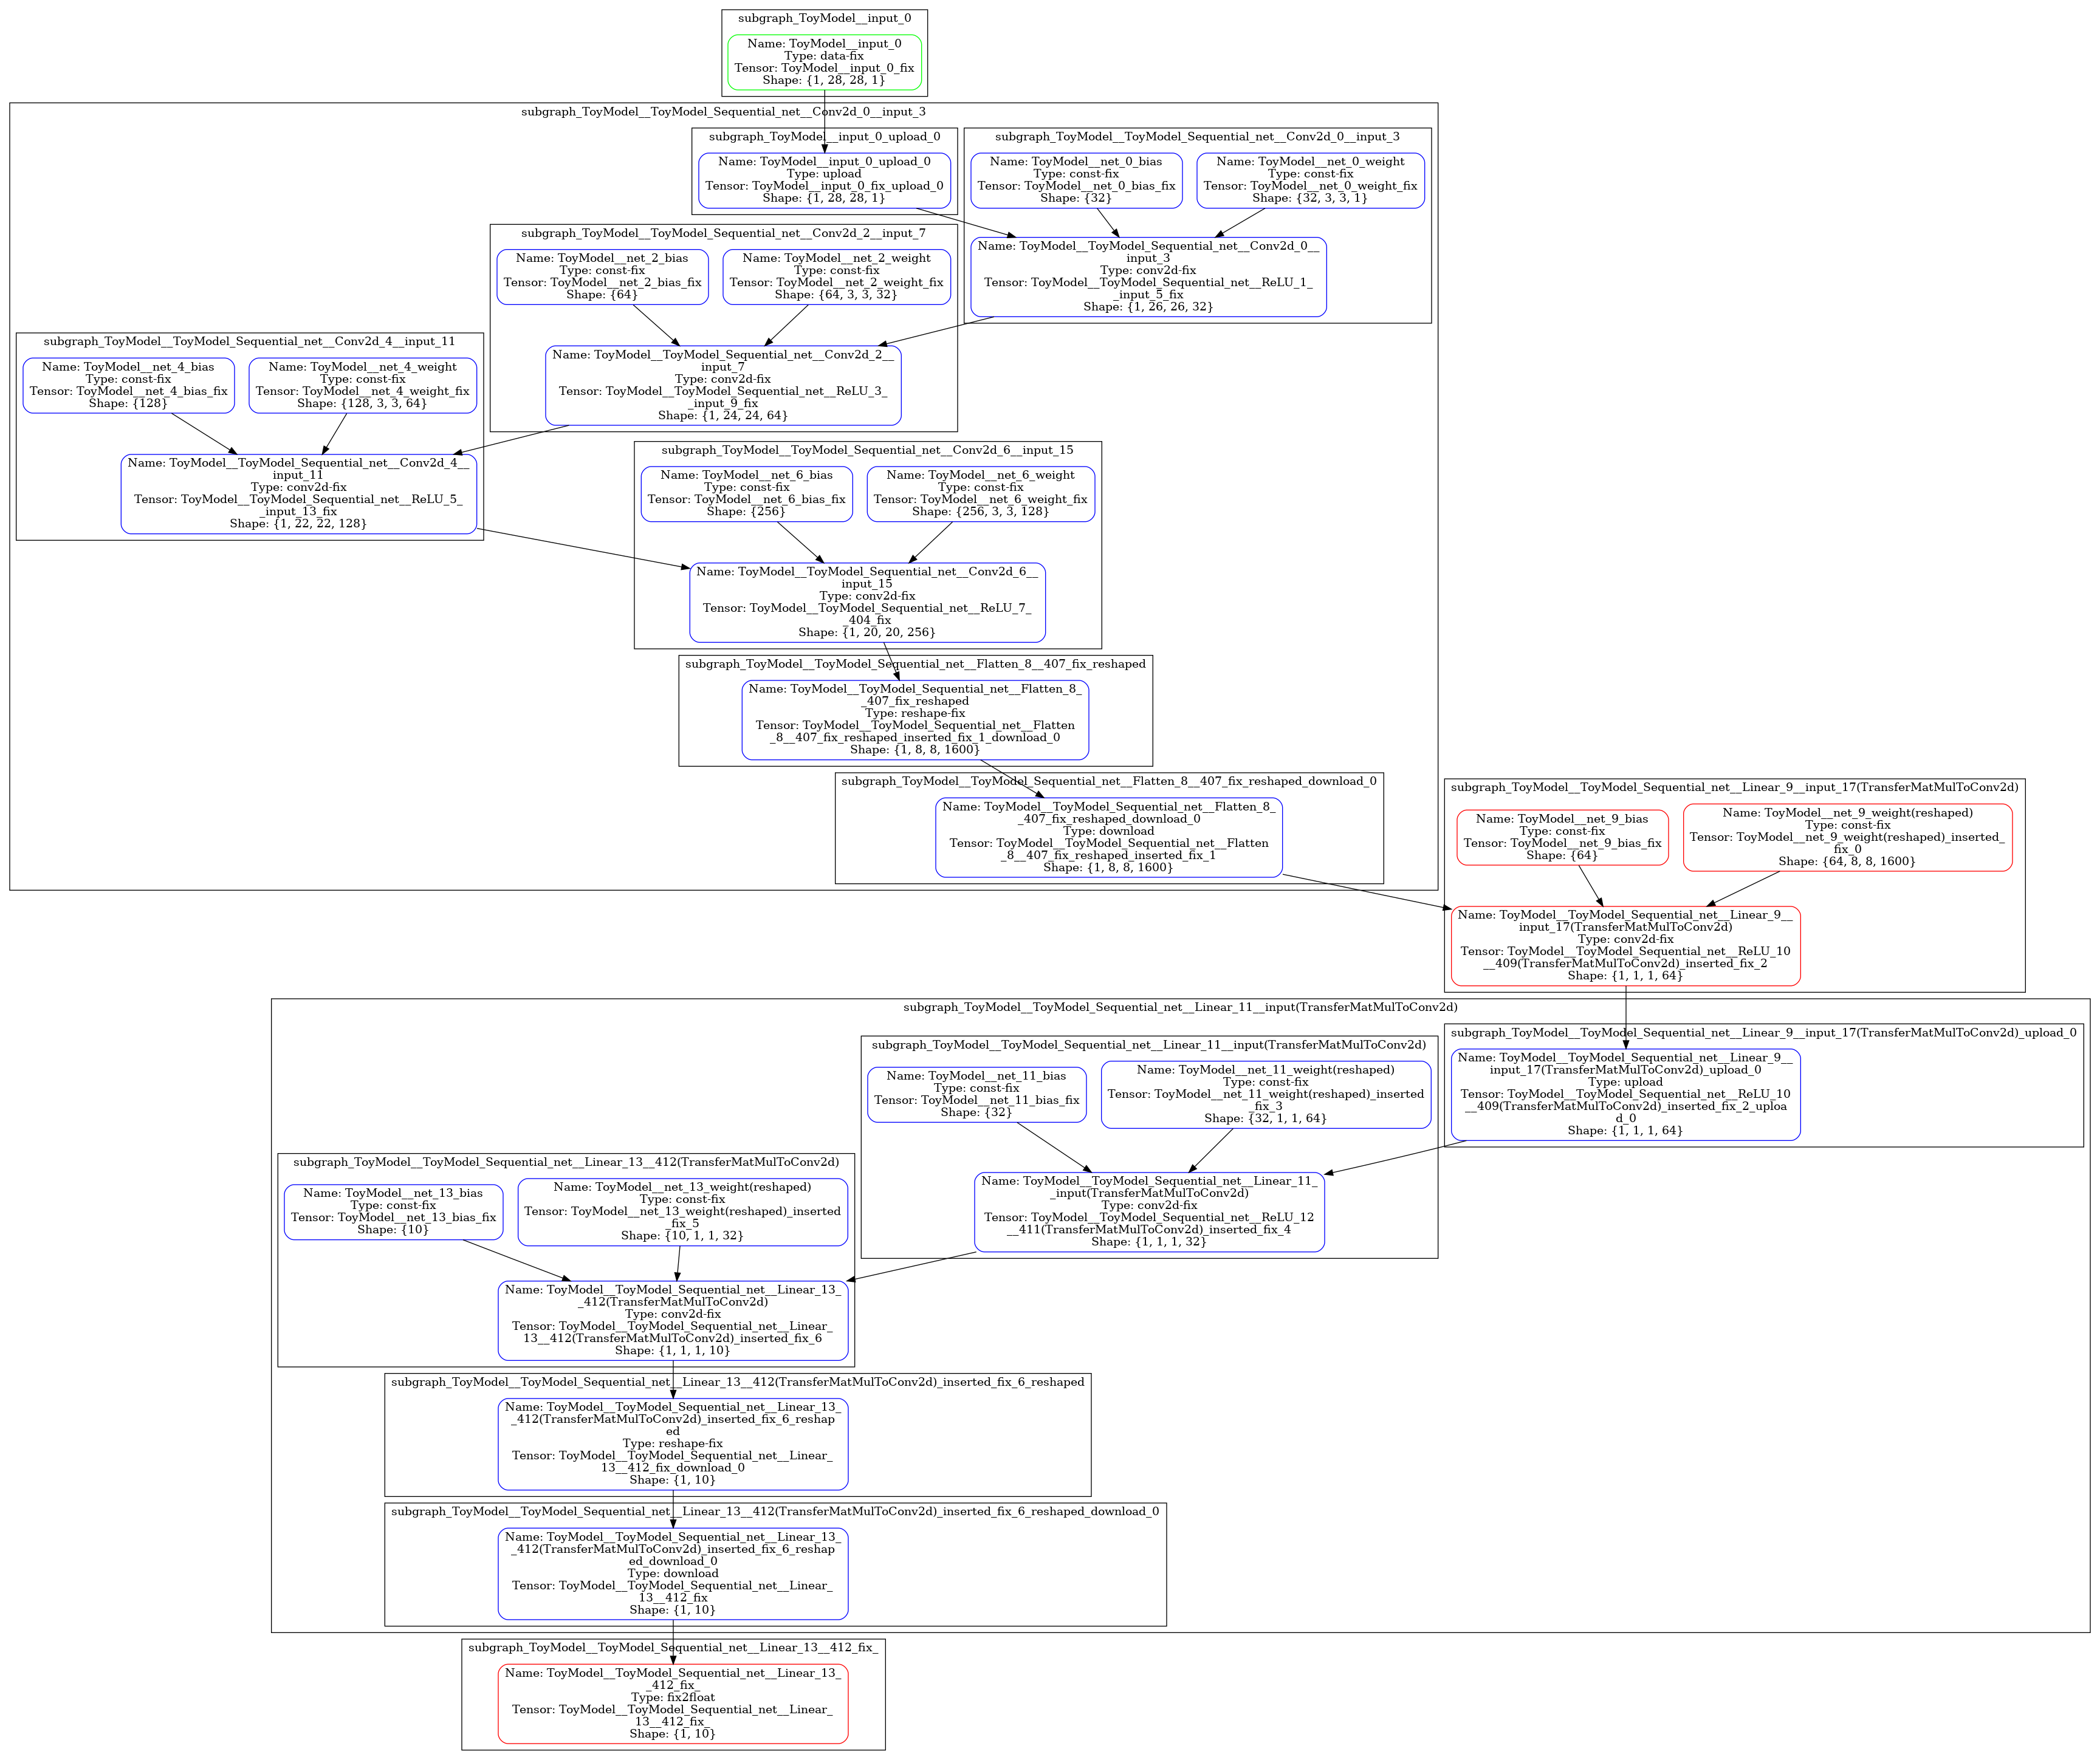

In [21]:
Image('compiled_model/compiled_xmodel.png')

### The compilation step generates a warning:

`[UNILOG][WARNING] xir::Op{name = ToyModel__ToyModel_Sequential_net__Linear_9__input_17(TransferMatMulToConv2d), type = conv2d-fix} has been assigned to CPU: [Weights(64, 8, 8, 1600) is too large to be loaded into parameter buffer. "kernel_h * kernel_w * kernel_d(=1 for conv2d) * ⌈input_channel / weights_bank_width⌉ * ⌈output_channel_parallel / weights_bank_num⌉"(6400) is supposed to be less equal than 2048].
[UNILOG][WARNING] xir::Op{name = ToyModel__net_9_weight(reshaped), type = const-fix} has been assigned to CPU: [Has no fanout or at least one fanout is out of DPU subgraph.].
[UNILOG][WARNING] xir::Op{name = ToyModel__net_9_bias, type = const-fix} has been assigned to CPU: [Has no fanout or at least one fanout is out of DPU subgraph.].`

From the xmodel graph, it is apparent that some layers have been assigned to the CPU, mainly due to the in_features size of the Linear layer. While this isn't an error and won't prevent the model from running, the distribution of operations between the CPU and DPU is likely to incur a performance cost.

Upon closer inspection of the warning, we can deduce that the DPU's support for the fully connected layer is limited to 2048* channel parallel. However, in our model, it is 256*20*20, which exceeds this limit.

For B4096, the channel_parallel is 16, so the maximum size of the input channel should be less than 204816 = 32768. However, in this linear layer, the input feature size is 256*20*20, surpassing this support. Therefore, it is advisable to adjust the value of the input features.

Refer to this section of PG338 for more details: https://docs.xilinx.com/r/en-US/pg338-dpu/Introduction?tocId=4lq1FtJ078vxzAJQVMkl_g

We've invested considerable time in model creation, testing, and training, only to find during the compilation stage that the DPU does not support the model parameters. This setback could have been avoided by using the Vitis Inspector during the model creation phase.

 

In [22]:
#This is our model that we created initially.
class ToyModel(nn.Module):
    def __init__(self):
        super(ToyModel, self).__init__()
        
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(in_features=256*20*20, out_features=64),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=64, out_features=32),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=32, out_features=10)
        )
        
    def forward(self, x):
        out = self.net(x)
        return out

# Lets Inspect

In [23]:
from pytorch_nndct.apis import Inspector

target = "0x101000016010407"
# Initialize inspector with target
inspector = Inspector(target)

model = ToyModel()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dummy_input = torch.randn(1,1,28,28)
inspector.inspect(model, (dummy_input,), device=device, output_dir="inspect", image_format="png") 


[VAIQ_NOTE]: Inspector is on.

[VAIQ_NOTE]: =>Start to inspect model...

[VAIQ_NOTE]: =>Quant Module is in 'cuda'.

[VAIQ_NOTE]: =>Parsing ToyModel...

[VAIQ_NOTE]: Start to trace and freeze model...

[VAIQ_NOTE]: The input model ToyModel is torch.nn.Module.

[VAIQ_NOTE]: Finish tracing.

[VAIQ_NOTE]: Processing ops...


██████████████████████████████████████████████████| 16/16 [00:00<00:00, 608.00it/s, OpInfo: name = return_0, type = Return]     


[VAIQ_NOTE]: =>Doing weights equalization...

[VAIQ_NOTE]: =>Quantizable module is generated.(inspect/ToyModel.py)



[VAIQ_NOTE]: Find subgraph for convlike_fix_18:
node name:ToyModel::ToyModel/Sequential[net]/Linear[9]/input.17, op type:nndct_dense, output shape: [1, 64]
node name:ToyModel::ToyModel/Sequential[net]/ReLU[10]/409, op type:nndct_relu, output shape: [1, 64]



[VAIQ_NOTE]: Find subgraph for convlike_fix_18:
node name:ToyModel::ToyModel/Sequential[net]/Conv2d[0]/input.3, op type:nndct_conv2d, output shape: [1, 26, 26, 32]
node name:ToyModel::ToyModel/Sequential[net]/ReLU[1]/input.5, op type:nndct_relu, output shape: [1, 26, 26, 32]



[VAIQ_NOTE]: Find subgraph for convlike_fix_18:
node name:ToyModel::ToyModel/Sequential[net]/Conv2d[2]/input.7, op type:nndct_conv2d, output shape: [1, 24, 24, 64]
node name:ToyModel::ToyModel/Sequential[net]/ReLU[3]/input.9, op type:nndct_relu, output shape: [1, 24, 24, 64]



[VAIQ_NOTE]: Find subgraph for convlike_fix_18:
node name:ToyModel::ToyModel/Sequential[net]/Linear[11]/input, op type:nndct_dense, output shape: [1, 32]
node name:ToyModel::ToyMode

I20230430 06:06:15.377419   585 compile_pass_manager.cpp:287] [UNILOG][INFO] Compile mode: dpu
I20230430 06:06:15.377451   585 compile_pass_manager.cpp:288] [UNILOG][INFO] Debug mode: null
I20230430 06:06:15.377465   585 compile_pass_manager.cpp:292] [UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096_0101000016010407
I20230430 06:06:15.377525   585 compile_pass_manager.cpp:357] [UNILOG][INFO] Graph name: nndct_dense_nndct_relu_XCkah9wc6KFby8Po, with op num: 9
I20230430 06:06:15.377537   585 compile_pass_manager.cpp:370] [UNILOG][INFO] Begin to compile...
W20230430 06:06:15.642925   585 PartitionPass.cpp:3741] [UNILOG][WARNING] xir::Op{name = ToyModel__ToyModel_Sequential_net__Linear_9__input_17(TransferMatMulToConv2d), type = conv2d-fix} has been assigned to CPU: [Weights(64, 8, 8, 1600) is too large to be loaded into parameter buffer. "kernel_h * kernel_w * kernel_d(=1 for conv2d) * ⌈input_channel / weights_bank_width⌉ * ⌈output_channel_parallel / weights_bank_num⌉"(6400) is sup


[VAIQ_NOTE]: Find subgraph for convlike_fix_20:
node name:ToyModel::ToyModel/Sequential[net]/Linear[13]/412, op type:nndct_dense, output shape: [1, 10]



[VAIQ_NOTE]: The operators assigned to the CPU are as follows(see more details in 'inspect/inspect_0x101000016010407.txt'):


I20230430 06:06:15.758428   585 compile_pass_manager.cpp:287] [UNILOG][INFO] Compile mode: dpu
I20230430 06:06:15.758456   585 compile_pass_manager.cpp:288] [UNILOG][INFO] Debug mode: null
I20230430 06:06:15.758466   585 compile_pass_manager.cpp:292] [UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096_0101000016010407
I20230430 06:06:15.758534   585 compile_pass_manager.cpp:357] [UNILOG][INFO] Graph name: nndct_dense_FLMPmCpS6K8hoZnq, with op num: 8
I20230430 06:06:15.758545   585 compile_pass_manager.cpp:370] [UNILOG][INFO] Begin to compile...
W20230430 06:06:16.023308   585 PartitionPass.cpp:3741] [UNILOG][WARNING] xir::Op{name = ToyModel__ToyModel_Sequential_net__Linear_9__input_17(TransferMatMulToConv2d), type = conv2d-fix} has been assigned to CPU: [Weights(64, 8, 8, 1600) is too large to be loaded into parameter buffer. "kernel_h * kernel_w * kernel_d(=1 for conv2d) * ⌈input_channel / weights_bank_width⌉ * ⌈output_channel_parallel / weights_bank_num⌉"(6400) is supposed to be

node name                                              op Type      hardware constraints
-----------------------------------------------------  -----------  ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
ToyModel::ToyModel/Sequential[net]/Linear[9]/input.17  nndct_dense  xir::Op{name = ToyModel__ToyModel_Sequential_net__Linear_9__input_17(TransferMatMulToConv2d), type = conv2d-fix} has been assigned to CPU: [Weights(64, 8, 8, 1600) is too large to be loaded into parameter buffer. "kernel_h * kernel_w * kernel_d(=1 for conv2d) * ⌈input_channel / weights_bank_width⌉ * ⌈output_channel_parallel / weights_bank_num⌉"(6400) is supposed to be less equal

### In the above log we can see that Inspector also gives us warning or hardware constraints similar to what was outputted by the Vitis compiler

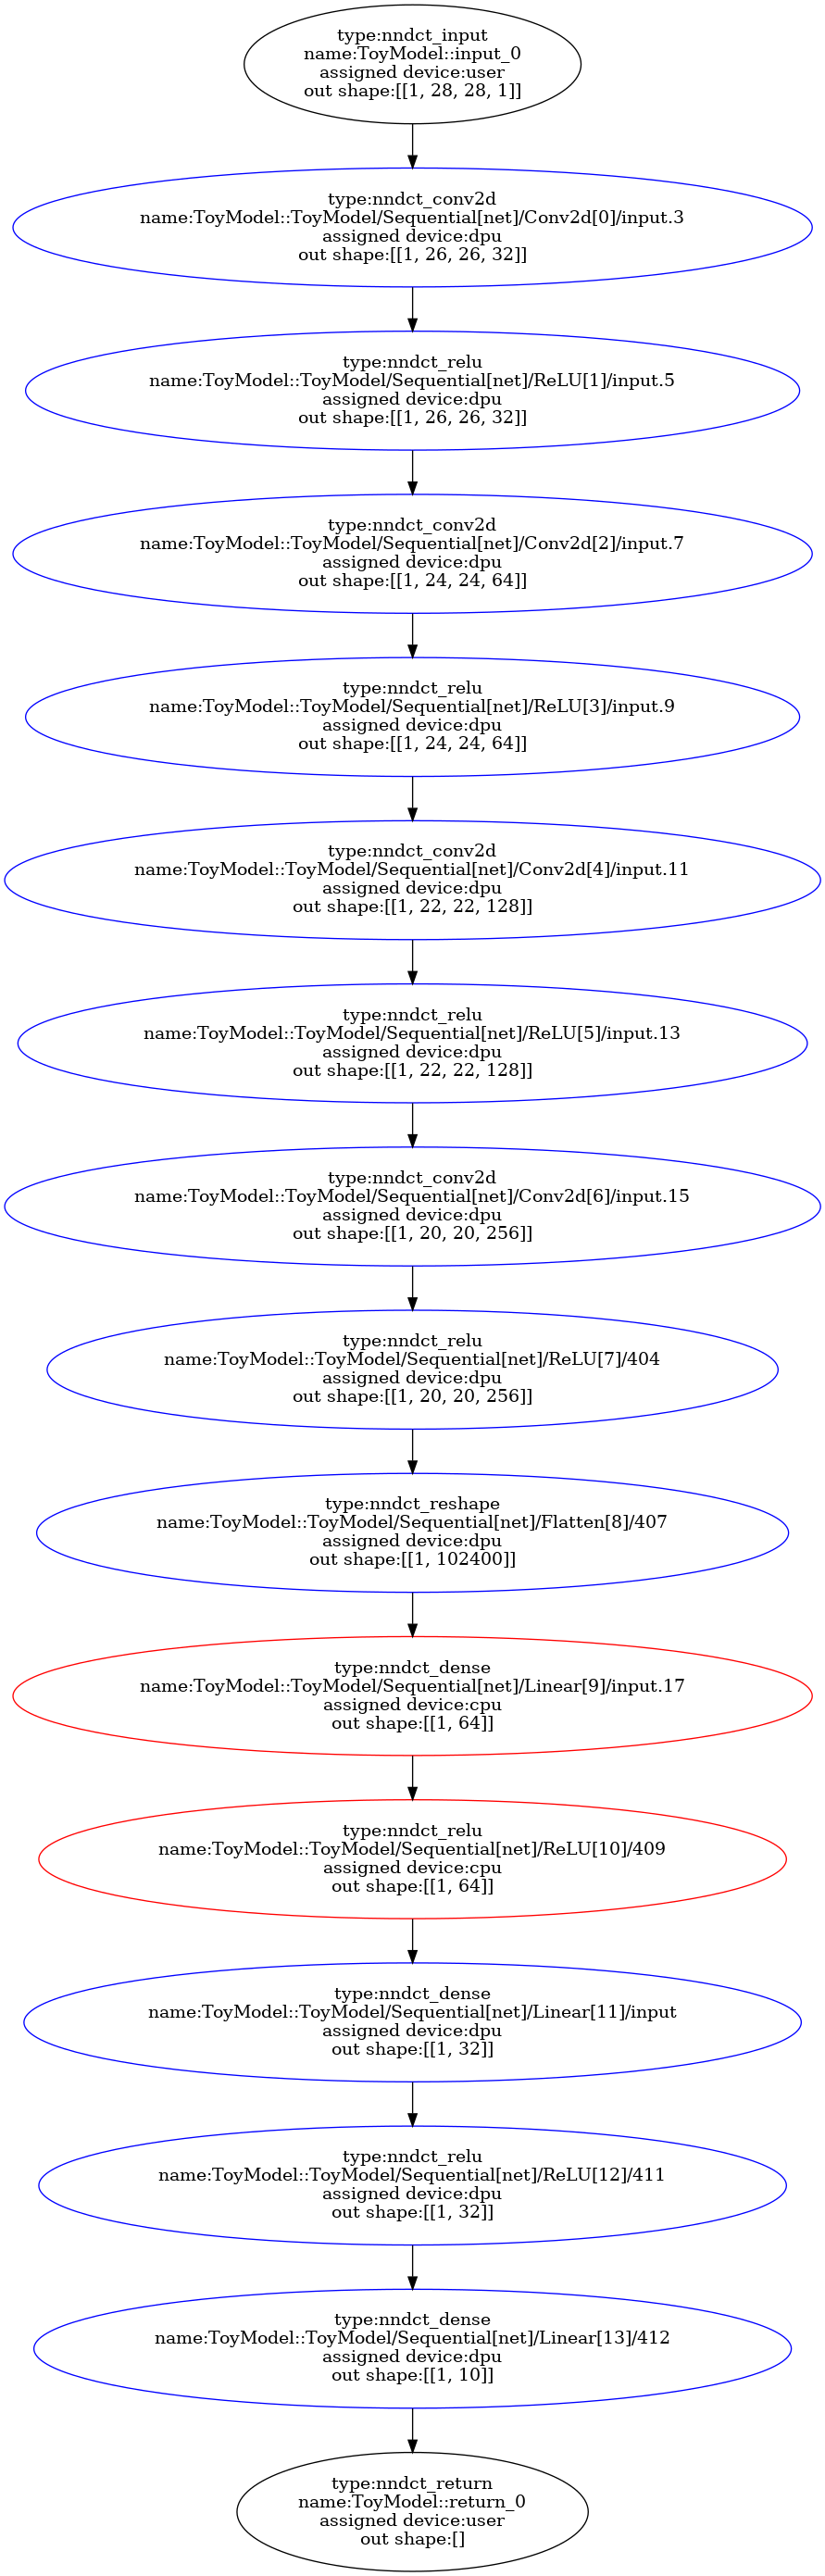

In [24]:
Image('inspect/inspect_0x101000016010407.png')

### The inspection graph shows that nndct_dense layer will be assigned to CPU. This is known as those layers assigned to CPU will be encircled red whereas the layers encircled blue will be assigned to dpu.
### For a more in-depth analysis, the Inspector also exports a detailed log, layer by layer, into a text file. This resource can be particularly helpful for deeper debugging and understanding of the underlying issues. This way, we can address potential problems more effectively and improve the overall efficiency of our model.

# Modifying the Network
### Given the information we've acquired, let's proceed to adjust the in_features parameter, also known as the input channels of our linear layer. This adjustment requires a corresponding modification in the channels of our convolutional network to ensure consistency throughout the model. This process will help us to comply with the constraints of the DPU and improve the efficiency of our model.

In [30]:
#New Model
# Define the model
class NewToyModel(nn.Module):
    def __init__(self):
        super(NewToyModel, self).__init__()
        
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3), # output: 26x26
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3), # output: 24x24
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3), # output: 22x22
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3), # output: 20x20
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(in_features=64*20*20, out_features=64), # based on 20x20 spatial dimensions after the last conv layer
            nn.ReLU(inplace=True),
            nn.Linear(in_features=64, out_features=32),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=32, out_features=10) # MNIST has 10 classes
        )
        
    def forward(self, x):
        out = self.net(x)
        return out

In [31]:
from pytorch_nndct.apis import Inspector

target = "0x101000016010407"
# Initialize inspector with target
inspector = Inspector(target)

model = NewToyModel()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dummy_input = torch.randn(1,1,28,28)
inspector.inspect(model, (dummy_input,), device=device, output_dir="new_inspect", image_format="png") 


[VAIQ_NOTE]: Inspector is on.

[VAIQ_NOTE]: =>Start to inspect model...

[VAIQ_NOTE]: =>Quant Module is in 'cuda'.

[VAIQ_NOTE]: =>Parsing NewToyModel...

[VAIQ_NOTE]: Start to trace and freeze model...

[VAIQ_NOTE]: The input model NewToyModel is torch.nn.Module.

[VAIQ_NOTE]: Finish tracing.

[VAIQ_NOTE]: Processing ops...


██████████████████████████████████████████████████| 16/16 [00:00<00:00, 808.83it/s, OpInfo: name = return_0, type = Return]     


[VAIQ_NOTE]: =>Doing weights equalization...

[VAIQ_NOTE]: =>Quantizable module is generated.(new_inspect/NewToyModel.py)



[VAIQ_NOTE]: Find subgraph for convlike_fix_18:
node name:NewToyModel::NewToyModel/Sequential[net]/Conv2d[0]/input.3, op type:nndct_conv2d, output shape: [1, 26, 26, 16]
node name:NewToyModel::NewToyModel/Sequential[net]/ReLU[1]/input.5, op type:nndct_relu, output shape: [1, 26, 26, 16]



[VAIQ_NOTE]: Find subgraph for convlike_fix_18:
node name:NewToyModel::NewToyModel/Sequential[net]/Linear[11]/input, op type:nndct_dense, output shape: [1, 32]
node name:NewToyModel::NewToyModel/Sequential[net]/ReLU[12]/411, op type:nndct_relu, output shape: [1, 32]



[VAIQ_NOTE]: Find subgraph for convlike_fix_18:
node name:NewToyModel::NewToyModel/Sequential[net]/Conv2d[4]/input.11, op type:nndct_conv2d, output shape: [1, 22, 22, 64]
node name:NewToyModel::NewToyModel/Sequential[net]/ReLU[5]/input.13, op type:nndct_relu, output shape: [1, 22, 22, 64]



[VAIQ_NOTE]: Find subgraph for convlike_fix_18:
node name:NewToyModel::NewToyModel/Sequential[net]/Linear[9]/input.17, op type:nndct_dense, outpu

I20230430 06:12:57.620277   585 compile_pass_manager.cpp:287] [UNILOG][INFO] Compile mode: dpu
I20230430 06:12:57.620307   585 compile_pass_manager.cpp:288] [UNILOG][INFO] Debug mode: null
I20230430 06:12:57.620316   585 compile_pass_manager.cpp:292] [UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096_0101000016010407
I20230430 06:12:57.620398   585 compile_pass_manager.cpp:357] [UNILOG][INFO] Graph name: nndct_conv2d_nndct_relu_7mZf1BVnGCIa8UQK, with op num: 9
I20230430 06:12:57.620409   585 compile_pass_manager.cpp:370] [UNILOG][INFO] Begin to compile...
I20230430 06:12:57.625331   585 compile_pass_manager.cpp:381] [UNILOG][INFO] Total device subgraph number 3, DPU subgraph number 1
I20230430 06:12:57.625367   585 compile_pass_manager.cpp:386] [UNILOG][INFO] Compile done.
I20230430 06:12:57.631353   585 compile_pass_manager.cpp:287] [UNILOG][INFO] Compile mode: dpu
I20230430 06:12:57.631378   585 compile_pass_manager.cpp:288] [UNILOG][INFO] Debug mode: null
I20230430 06:12:57.63


[VAIQ_NOTE]: Dot image is generated.(new_inspect/inspect_0x101000016010407.png)

[VAIQ_NOTE]: =>Finish inspecting.


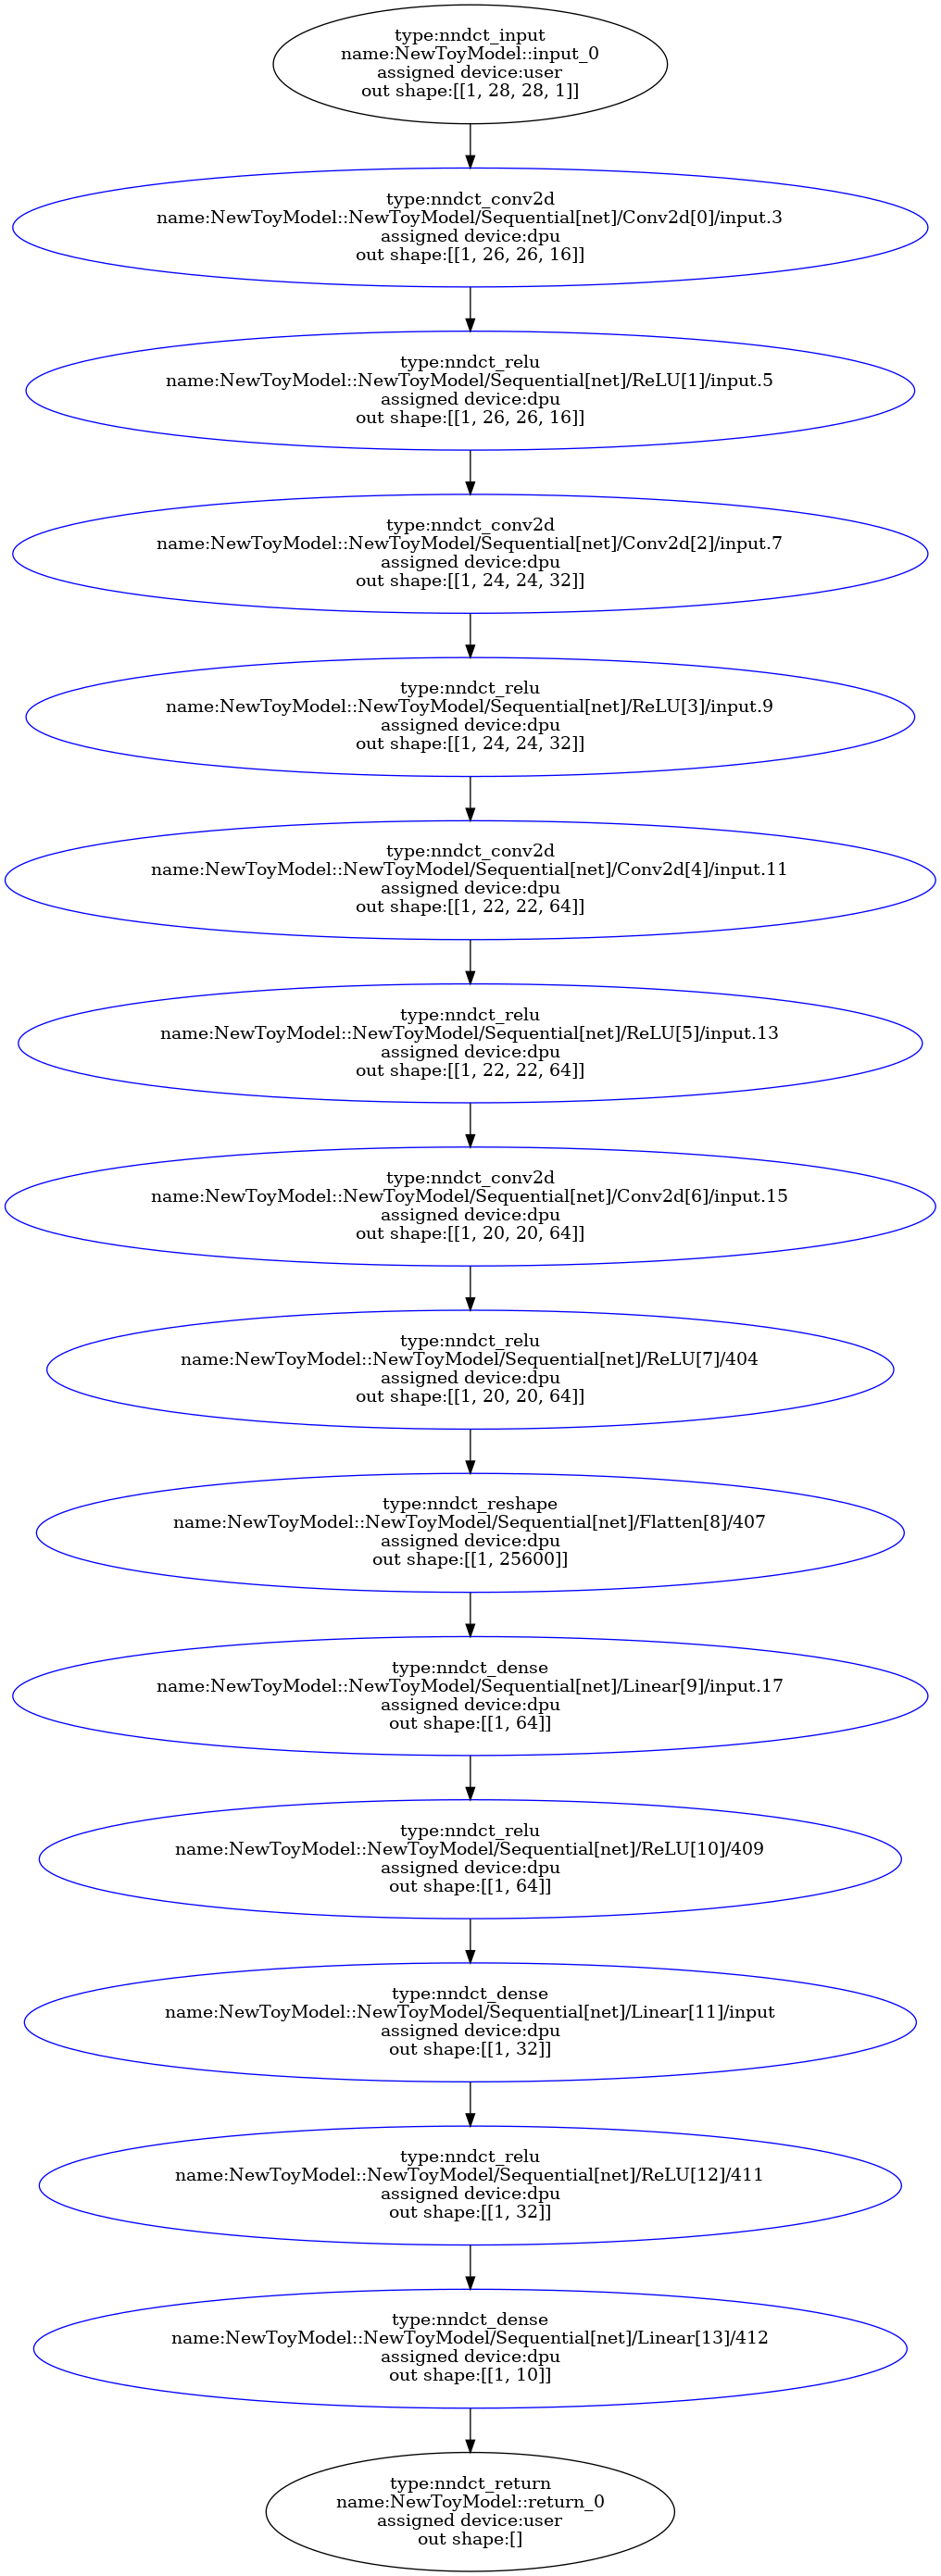

In [32]:
Image('new_inspect/inspect_0x101000016010407.png')

### After making the necessary modifications, the Inspector no longer raises any warnings. The graph also indicates that all layers have now been assigned to the DPU. Utilizing the Model Inspector can significantly streamline the process from Model Creation to Deployment, saving us a considerable amount of time.

### This instance serves as a simple yet illustrative example of the utility of the Vitis Inspector. If you're troubleshooting issues, this tool can provide invaluable insights to enhance your model development from the start.
